In [27]:
import numpy as np
import scipy as scipy
from sklearn.decomposition import PCA
import argparse
import os
import myfun as mf
import pickle as pkl

import matplotlib
from matplotlib import gridspec, rc
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
# params
nsamp     = 100
bin_sz    = 1000
npc       = 1
np.random.seed(None)

In [6]:
# # r / w
# print('creating output directory at {0}'.format(args.outdir))
# os.makedirs(args.outdir, exist_ok = True)
headdir    = '/Users/simonfreedman/cqub/bifurc/paper_figs/' #'.' #'/Users/simonfreedman/cqub/bifurc/weinreb_2020/'
figdir     = '{0}/figs'.format(headdir)
datdir     = '{0}/neutrophil_data'.format(headdir)
eigdir     = '{0}/eig'.format(datdir)

gexp_fname = '{0}/gene_expr.npz'.format(datdir)
print('loading gene expr matrix')
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # ~ 20s (filesize is 1.1GB)
gexp_lil   = gexp_sp.tolil() # ~4min
print('done loading gene expr matrix')

loading gene expr matrix
done loading gene expr matrix


In [7]:
with open('{0}/bin_cidxs.pkl'.format(eigdir),'rb') as f:
    bin_cidxs = pkl.load(f)

In [12]:
npst = len(bin_cidxs)

In [14]:
ngene = gexp_lil.shape[1]

In [19]:
ts = [109,87]

cov_evec_shuf           = np.zeros((len(ts), nsamp,ngene))
npc = 1
for ti,t in enumerate(ts):
    gexpt        = gexp_lil[bin_cidxs[t]].toarray()
    ncell, ngene = gexpt.shape
    
    for i in range(nsamp):
        pca                 = PCA(n_components=npc)
        gexp_shuf = np.array([gexpt[:,g][np.random.choice(ncell, ncell, replace=True)] 
                              for g in range(ngene)]).T
        pca.fit(gexp_shuf)
        #cov_evals_shuf[t,i]    = pca.explained_variance_
        #cov_eval_rat_shuf[t,i] = pca.explained_variance_ratio_
        cov_evec_shuf[ti,i]     = pca.components_[0]

In [21]:
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]

In [68]:
np.log10(np.abs(pst_pc1[ts[0]]))

<ipython-input-68-b576ec7722cd>:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(pst_pc1[ts[0]]))


array([-20.37878736,  -4.40982996,  -3.94449815, ...,  -3.86943474,
        -3.84172611,  -5.42413808])

In [73]:
zero_genes = np.where(pst_pc1[ts[0]]==0)[0]

In [114]:
gexpts        = np.array([gexp_lil[bin_cidxs[t]].toarray() for t in ts])

In [90]:
nz_genes = np.where(np.sum(gexpt,axis=0)>0)[0]

In [81]:
pca = PCA(n_components=1)
pca.fit(gexpt)

PCA(n_components=1)

In [115]:
gexpts.shape

(2, 1000, 25289)

In [118]:
bmax = np.amax(gexpts)
bmin = np.amin(gexpts[gexpts>0])
bins = np.hstack([-bmin,np.linspace(bmin, bmax+bmin,50)])
bins = np.hstack([-bmin,np.logspace(np.log10(bmin), np.log10(bmax+bmin),50)])

ghists = np.array([np.histogram(gexpts[i].reshape(-1),bins=bins)[0] for i in range(len(ts))]) 
bmids = 0.5*(bins[1:]+bins[:-1])

In [119]:
np.where(np.amax(gexpt,axis=0)>=10)[0].shape

(858,)

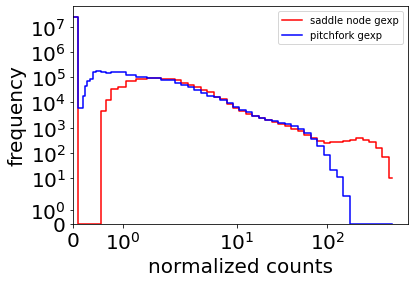

In [124]:
fig,axs=plt.subplots()
axs.step(bmids,ghists[0], where='mid', color='red',label='saddle node gexp')
axs.step(bmids,ghists[1], where='mid', color='blue', label='pitchfork gexp')

axs.set_yscale('symlog')
axs.set_xscale('symlog')
axs.set_xlim(xmin=0)
axs.set_ylim(ymin=0)

axs.legend()
axs.set_xlabel('normalized counts')
axs.set_ylabel('frequency')

mf.set_axs_fontsize(axs,20)

In [82]:
pca.explained_variance_

array([20065.99703633])

In [87]:
pca      = PCA(n_components=1)
nz_genes = np.where(np.sum(gexpt,axis=0)>0)[0]
pca.fit(gexpt[:,nz_genes])

PCA(n_components=1)

In [88]:
pca.explained_variance_

array([20065.99703633])

In [80]:
np.amin(gexpt[:,zero_genes])

0.0

<ipython-input-69-4cf8ab74e149>:2: RuntimeWarning: divide by zero encountered in log10
  axs.hist(np.log10(np.abs(pst_pc1[ts[0]])))


ValueError: supplied range of [-inf, -0.20621142293495268] is not finite

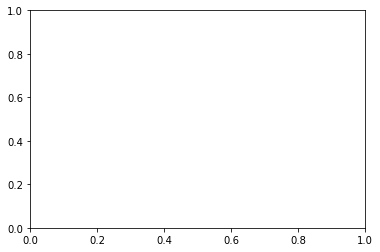

In [69]:
fig,axs=plt.subplots()
axs.hist(np.log10(np.abs(pst_pc1[ts[0]])))
#axs.set_yscale('log')
#axs.set_xscale('symlog',linthresh=1e-6)

In [20]:
cov_evec_shuf.shape

(2, 100, 25289)

In [32]:
bift_pc1_cc = pst_pc1[ts[0]].dot(pst_pc1[ts[1]])

In [24]:
np.corrcoef(pst_pc1[ts[0]],pst_pc1[ts[1]])

array([[ 1.    , -0.6147],
       [-0.6147,  1.    ]])

In [25]:
shuf_evec_corrcoef = cov_evec_shuf[0].dot(cov_evec_shuf[1].T)

In [126]:
cov_evec_shuf.shape, 

((2, 100, 25289),)

In [130]:
np.array_equal(cov_evec_shuf[1,0], cov_evec_shuf[1,1])

False

In [129]:
[cov_evec_shuf[0,k].dot(cov_evec_shuf[1,0]) for k in range(nsamp)]

[0.8891517133015058,
 0.5855742054089806,
 0.9521379595465324,
 0.6260334602576476,
 0.9191155138699082,
 0.7750961205686728,
 0.9345187466461683,
 -0.1050960136954972,
 0.9458316393790154,
 0.8600709571435267,
 0.01061878321013153,
 0.0407652354126528,
 0.4685453169789756,
 0.9911598531689106,
 -0.5114934361727974,
 -0.4527604821086578,
 0.09214697038950097,
 0.8908760815319109,
 0.37821762783110113,
 0.8611626795729729,
 0.921930492409402,
 0.9017548376422714,
 0.7436401756863413,
 -0.0634621493299845,
 0.5487169479366715,
 -0.31585101873340427,
 -0.1640693870532226,
 0.9819565725920926,
 -0.20758023947537715,
 -0.13317797019917837,
 0.23852688086773013,
 -0.6558800449695709,
 -0.02833268637964836,
 0.797925932717553,
 0.06253470776547808,
 0.7988974386350506,
 0.9470400205572008,
 0.6474617585164162,
 -0.6650335276732254,
 0.8569768730647721,
 0.9043490118746711,
 0.8213170877548198,
 -0.28195299099151494,
 0.6919340684323763,
 0.990743794210525,
 -0.7872325716520283,
 0.12033397227

In [36]:
shuf_evec_corrcoef.shape

(100, 100)

In [44]:
cov_evec_shuf[0].shape

(100, 25289)

In [45]:
cov_evec_shuf[1].shape

(100, 25289)

In [47]:
shuf_evec_corrcoef

array([[0.88915171, 0.89186757, 0.89223535, ..., 0.89311254, 0.8871507 ,
        0.87501743],
       [0.58557421, 0.58039111, 0.57846895, ..., 0.5727625 , 0.58626282,
        0.57362315],
       [0.95213796, 0.94642619, 0.95246184, ..., 0.94596606, 0.95440375,
        0.9348251 ],
       ...,
       [0.31539683, 0.31218722, 0.30720077, ..., 0.30134072, 0.31633148,
        0.30795854],
       [0.62905835, 0.63024066, 0.63501956, ..., 0.63814627, 0.62625591,
        0.61721064],
       [0.85162201, 0.85073732, 0.85706945, ..., 0.85675351, 0.85123148,
        0.83808818]])

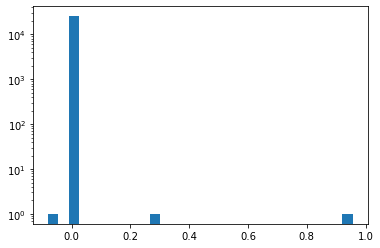

In [55]:
fig,axs=plt.subplots()
axs.hist(cov_evec_shuf[0,2],bins=30)
axs.set_yscale('log')

In [56]:
cov_evec_shuf

array([[[ 4.66338687e-17,  8.47489364e-05, -2.63761489e-04, ...,
          2.06951749e-04,  4.97190768e-04,  5.24364287e-06],
        [ 2.29279604e-18,  4.58999911e-05, -1.02019811e-04, ...,
         -2.54753710e-04,  9.98799838e-04, -1.83867269e-05],
        [-3.13597825e-17, -1.47132970e-04,  1.29936474e-04, ...,
         -4.42967057e-04, -4.82848703e-04,  1.53663103e-05],
        ...,
        [-1.43172833e-16, -2.43868601e-04, -2.63829866e-05, ...,
         -1.17852245e-04, -3.04020623e-04, -1.66447578e-05],
        [ 1.72949066e-18,  5.51126485e-05,  2.77098611e-05, ...,
         -1.54084521e-04, -7.42401319e-04,  1.06609050e-05],
        [-5.79550999e-17, -1.39853881e-04, -1.73969667e-04, ...,
         -7.58899490e-05, -5.36703379e-05,  0.00000000e+00]],

       [[-2.57160179e-19, -8.58512349e-04, -9.84260182e-05, ...,
         -3.82897813e-04, -4.39069621e-03, -8.55476134e-05],
        [ 1.13294326e-18,  5.47371570e-05, -2.01180919e-05, ...,
          5.78995559e-04, -2.02930438e

In [54]:
np.abs(np.amax(cov_evec_shuf[0,2]))

0.956151617847642

In [48]:
cov_evec_shuf[0,55].dot(cov_evec_shuf[1,32])

0.5460507724808198

In [50]:
shuf_evec_corrcoef[32,55]

-0.004739558622709513

In [42]:
shuf_evec_corrcoef_flat = shuf_evec_corrcoef.reshape(-1) # np.hstack([shuf_evec_corrcoef[i,i+1:] for i in range(nsamp)])

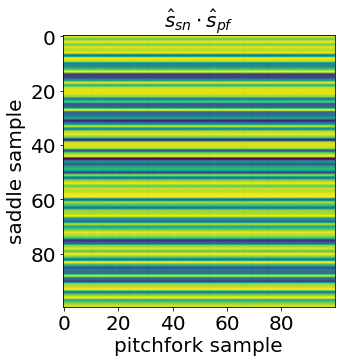

In [137]:
fig,axs=plt.subplots(figsize=(5,5))
axs.imshow(shuf_evec_corrcoef, aspect=1)
axs.set_xlabel('pitchfork sample')
axs.set_ylabel('saddle sample')
axs.set_title(r'$\hat{s}_{sn}\cdot \hat{s}_{pf}$')

mf.set_axs_fontsize(axs,20)

In [38]:
shuf_evec_corrcoef_flat.shape

(4950,)

In [40]:
np.where(shuf_evec_corrcoef>0.9)

(array([], dtype=int64), array([], dtype=int64))

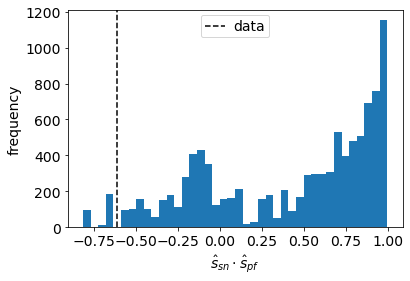

In [141]:
fig,axs=plt.subplots()
axs.hist(shuf_evec_corrcoef_flat,bins=40)

axs.axvline(bift_pc1_cc,color='black', linestyle='--',label='data')
axs.legend()
axs.set_xlabel('$\hat{s}_{sn}\cdot \hat{s}_{pf}$')
axs.set_ylabel('frequency')

mf.set_axs_fontsize(axs, 14, True)

In [18]:
nsamp

100

In [ ]:
# # load pseudotime cell indexes
# print('binning by pseudotime')
# tau         = np.genfromtxt(args.pst_fname, skip_header=True)
# if args.tau_bins:
#     pst_bins = mf.get_time_bin_idxs(tau[:,1], bin_sz, args.ov_frac) # returns indexes of tau
# else:
#     pst_bins = mf.get_bin_idxs(tau[:,1], bin_sz, args.ov_frac) #returns elements of "srt" which are indexes of tau

# bin_cidxs   = [np.array(tau[grp,0], dtype = 'int')  for grp in pst_bins]
# bin_time    = np.array([mf.meanor0(tau[grp,1])         for grp in pst_bins])
# npst        = len(bin_cidxs)

# print('saving bins')
# with open('{0}/bin_cidxs.pkl'.format(args.outdir), 'wb') as output_file:
#     pkl.dump(bin_cidxs, output_file)

# np.save('{0}/bin_psts.npy'.format(args.outdir), bin_time)

# run sampling
print('sampling')

cov_evals           = np.zeros([npst, npc])
cov_eval_rat        = np.zeros([npst, npc])
cov_evecs           = np.zeros((npst, npc, gexp_lil.shape[1]))

cov_evals_shuf      = np.zeros([nsamp, npc])
cov_evals_boot      = np.zeros([nboot, npc])

cov_eval_rat_shuf   = np.zeros([nsamp, npc])
cov_eval_rat_boot   = np.zeros([nboot, npc])

pca                 = PCA(n_components=npc)

ts = [109,87]

for t in ts:

    if len(bin_cidxs[t]) < npc + 1:
        print('at t = {0}, ncells = {1}, so skipping pca (npc = {2})'.format(t, len(pst_bins[t]), npc))
        continue

    ts.append(t)
    if t%5 == 0:
        print('bin {0}/{1}'.format(t,npst))

    gexpt        = gexp_lil[bin_cidxs[t]].toarray()
    ncell, ngene = gexpt.shape

    pca.fit(gexpt)
    cov_evals[t]    = pca.explained_variance_
    cov_evecs[t]    = pca.components_
    cov_eval_rat[t] = pca.explained_variance_ratio_

    for i in range(nsamp):
        gexp_shuf = np.array([gexpt[:,g][np.random.choice(ncell, ncell, replace=True)] 
                              for g in range(ngene)]).T
        pca.fit(gexp_shuf)
        cov_evals_shuf[i]    = pca.explained_variance_
        cov_eval_rat_shuf[i] = pca.explained_variance_ratio_
    
    np.save('{0}/shuf_eval_t{1}.npy'.format(args.outdir, t), cov_evals_shuf)
    np.save('{0}/shuf_eval_rat_t{1}.npy'.format(args.outdir, t), cov_eval_rat_shuf)

    for i in range(nboot):
        cidxs     = np.random.choice(ncell, size=ncell, replace=True)

        while np.unique(cidxs).shape[0]==1: # redraw if the same cell is chosen bc can't be pca'd
            cidxs     = np.random.choice(ncell, size=ncell, replace=True)
        
        gexp_shuf = gexpt[cidxs,:]
        pca.fit(gexp_shuf)
        cov_evals_boot[i] = pca.explained_variance_
        cov_eval_rat_boot[i] = pca.explained_variance_ratio_
    
    np.save('{0}/boot_eval_t{1}.npy'.format(args.outdir, t), cov_evals_boot)    
    np.save('{0}/boot_eval_rat_t{1}.npy'.format(args.outdir, t), cov_eval_rat_boot)
    
np.save('{0}/bin_ids.npy'.format(args.outdir),  np.array(ts))
np.save('{0}/dat_evec.npy'.format(args.outdir), cov_evecs)
np.save('{0}/dat_eval.npy'.format(args.outdir), cov_evals)
np.save('{0}/dat_eval_rat.npy'.format(args.outdir), cov_eval_rat)

In [143]:
neg_binom_dir = '{0}/neg_binom_sinkhorn_pca'.format(datdir)

In [145]:
nt = len(bin_cidxs)

In [151]:
evals = np.array([np.load('{0}/eval/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t))[:100] for t in range(nt)])

In [156]:
mshape = np.array([np.load('{0}/mat_shape/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t)) for t in range(nt)])

In [180]:
#mshape

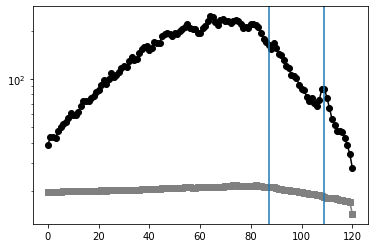

In [168]:
fig,axs=plt.subplots()
axs.plot(np.arange(nt), evals[:,0],'ko-')
#axs.plot(np.arange(nt), evals[:,1],'bo-')
#axs.plot(np.arange(nt), evals[:,2],'ro-')

axs.set_yscale('log')

axs.plot(np.arange(nt), mshape[:,3],'s-',color='grey')
for t in ts:
    axs.axvline(t)

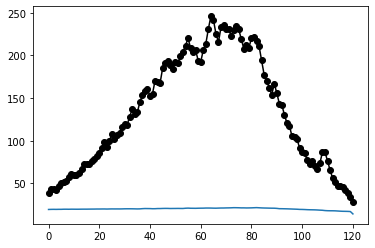

In [183]:
fig,axs=plt.subplots()
axs.plot(mshape[:,3])
axs.plot(evals[:,0],'ko-')


In [184]:
evals.shape

(121, 100)

In [186]:
np.where(evals[0]>mshape[0,3])[0]

array([0])

In [222]:
e1_sk = [np.load('{0}/evec/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t))[0] for t in range(nt)]
nzgidx = [np.load('{0}/nz_gidx/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t)) for t in range(nt)]
e1_full = np.zeros((nt, ngene))
for t in range(nt):
    e1_full[t,nzgidx[t]]=e1_sk[t]

In [223]:
evec_proj = e1_full.dot(e1_full.T)

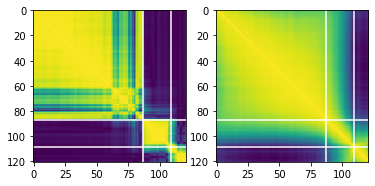

In [234]:
fig,axs=plt.subplots(1,2)
#im=axs.imshow(np.abs(evec_proj))
im1=axs[0].imshow(np.abs(pst_pc1_proj))
im2=axs[1].imshow(np.abs(evec_proj))


for t in ts:
    for ax in axs:
        ax.axvline(t,color='white')
        ax.axhline(t,color='white')
    
# divider = make_axes_locatable(axs)
# cax = divider.append_axes("right", size="7%", pad=0.2)

# plt.colorbar(im, cax=cax)

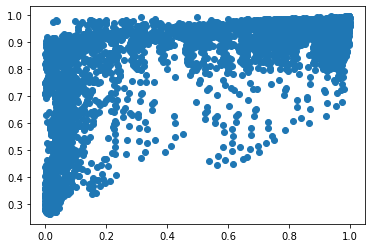

In [241]:
fig,axs=plt.subplots()
axs.scatter(np.abs(cc1),np.abs(cc2))

In [238]:
cc1 = np.hstack([pst_pc1_proj[i,i+1:] for i in range(nt)])
cc2 = np.hstack([evec_proj[i,i+1:] for i in range(nt)])

In [228]:
pst_pc1_proj = pst_pc1.dot(pst_pc1.T)

In [ ]:
fig,axs=plt.subplots()

In [170]:
evec0 = [np.load('{0}/evec/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t))[0] for t in range(nt)]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [187]:
t=0
e1 = np.load('{0}/evec/neut_bsz1000_bin{1}.npy'.format(neg_binom_dir, t))

In [212]:
e1_full = np.zeros(ngene)
e1_full[nzgidx]=e1[0]

In [213]:
e1_full

array([0.        , 0.00660967, 0.0013955 , ..., 0.00965714, 0.03151239,
       0.0013469 ])

In [196]:
pst_pc1[0]

array([ 2.71406094e-05, -1.45952967e-03,  2.49309989e-05, ...,
        3.10584224e-03,  2.83321644e-02,  2.10459650e-05])

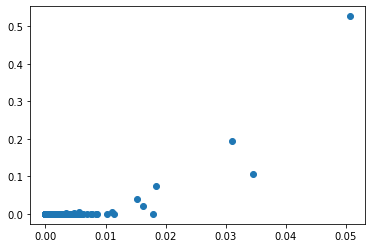

In [207]:
fig,axs=plt.subplots()
axs.scatter(e1_full[nzgidx]**2, pst_pc1[0,nzgidx]**2)

Text(0, 0.5, 'frequency')

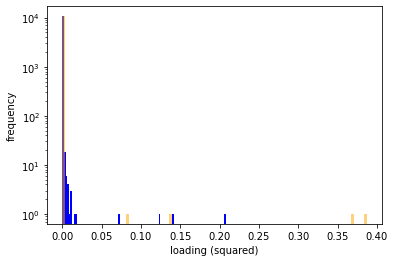

In [247]:
fig,axs=plt.subplots()
axs.hist(e1_full[ts[0],nzgidx[ts[0]]]**2,100,color='blue')
axs.hist(pst_pc1[ts[0],nzgidx[ts[0]]]**2,100,color='orange',alpha=0.5)
axs.set_yscale('log')
#axs.set_xscale('log')
axs.set_xlabel('loading (squared)')
axs.set_ylabel('frequency')

In [215]:
ts = [109,87]

cov_evec_shuf           = np.zeros((len(ts), nsamp,ngene))
npc = 1
for ti,t in enumerate(ts):
    
    gct_nz     = gct[nzgidx,:].T #Nc x Ng
#    usq, vsq,_ = sinkhorn((1+alpha[nzgidx])*gct_nz)
    usq = np.load('{0}/{1}.npy'.format(usq_dir, fnm))
    vsq = np.load('{0}/{1}.npy'.format(vsq_dir, fnm))    
    
    gct_til    = np.diag(np.sqrt(usq))@gct_nz@np.diag(np.sqrt(vsq))

    print('\nrunning PCA\n')
    # PCA
    gct_pca   = PCA().fit(gct_til)
    evals     = gct_pca.explained_variance_
    eval_lim  = lmax(gct_til)
    asp_rat   = 1./np.divide(*gct_til.shape) # num_columns / num rows
    nhi_eval  = np.where(evals>eval_lim)[0].shape[0]
    
    gexpt        = gexp_lil[bin_cidxs[t]].toarray()
    ncell, ngene = gexpt.shape
    
    for i in range(nsamp):
        pca                 = PCA(n_components=npc)
        gexp_shuf = np.array([gexpt[:,g][np.random.choice(ncell, ncell, replace=True)] 
                              for g in range(ngene)]).T
        pca.fit(gexp_shuf)
        #cov_evals_shuf[t,i]    = pca.explained_variance_
        #cov_eval_rat_shuf[t,i] = pca.explained_variance_ratio_
        cov_evec_shuf[ti,i]     = pca.components_[0]

(1836,)

In [211]:
e1.shape

(1, 11716)

In [205]:
np.where(e1_full[nzgidx]==0)

(array([], dtype=int64),)

In [169]:
evec0.shape

NameError: name 'evec0' is not defined